## 1. Setup

In [1]:
import sys
sys.path.append('..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os

from keras.callbacks import ModelCheckpoint
from unet import unet
from utils.dataset_utils import load_dataset_split
from utils.input_output import read_json, write_json
from utils.vis_utils import plot_image_mask_prediction, plot_train_val

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### 1.1 Change parameters of the experiment (and hyperparameters from ../config.py)

In [4]:
UNET_NAME = config.UNET_NAME
EXPERIMENT_NAME = config.EXPERIMENT_NAME
DATASET_PATH = f'../datasets/{config.DATASET_NAME}'

In [5]:
CHECKPOINTS_PATH = f'../checkpoints'
CHECKPOINT_FILENAME = f'{CHECKPOINTS_PATH}/{EXPERIMENT_NAME}/{UNET_NAME}.hdf5'
LOGS_PATH = f'../logs'
LOGS_FILENAME = f'{LOGS_PATH}/{EXPERIMENT_NAME}.json'
RESULTS_PATH = f'../results/{EXPERIMENT_NAME}'

In [6]:
!rm -rf $f'{CHECKPOINTS_PATH}/{EXPERIMENT_NAME}'
os.makedirs(f'{CHECKPOINTS_PATH}/{EXPERIMENT_NAME}')

## 2. Load the dataset splits

In [7]:
train_images, train_masks, train_img_names = load_dataset_split(DATASET_PATH, 'train')
val_images, val_masks, val_img_names = load_dataset_split(DATASET_PATH, 'val')
test_images, test_masks, test_img_names = load_dataset_split(DATASET_PATH, 'test')

train_masks = train_masks[..., np.newaxis]
val_masks = val_masks[..., np.newaxis]
test_masks = test_masks[..., np.newaxis]

print(train_images.shape, train_images.dtype, train_images.min(), train_images.max())
print(val_images.shape, val_images.dtype, val_images.min(), val_images.max())
print(val_img_names[:3])

(50, 512, 512, 3) float64 0.0 1.0
(10, 512, 512, 3) float64 0.0 1.0
['2601177796_b8e280ac8a_334_500_0_0.png', '2802725781_52d0e4061a_500_336_0_0.png', '2803811473_1ba769690b_327_500_0_0.png']


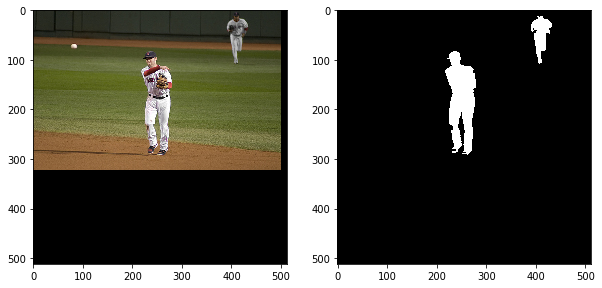

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_images[1])
plt.subplot(1, 2, 2)
plt.imshow(train_masks[1].squeeze(), cmap='gray')
plt.show()

## 3. Instantiate a U-Net

In [9]:
model = unet(input_shape=config.INPUT_SHAPE)

## 4. Train the model

In [10]:
%%time
model_checkpoint = ModelCheckpoint(CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   verbose=0,
                                   save_best_only=True)

model.fit(x=train_images, y=train_masks,
          validation_data=[val_images, val_masks],
          batch_size=config.BATCH_SIZE,
          epochs=config.NUM_EPOCHS,
          callbacks=[model_checkpoint])

Train on 50 samples, validate on 10 samples
Epoch 1/20
50/50 [==============================] - 55s 1s/step - loss: 0.3433 - acc: 0.9013 - tf_jaccard: 0.0093 - tf_dice: 0.0158 - val_loss: 0.1502 - val_acc: 0.9288 - val_tf_jaccard: 0.0141 - val_tf_dice: 0.0264
Epoch 2/20
50/50 [==============================] - 42s 842ms/step - loss: 0.1978 - acc: 0.9129 - tf_jaccard: 0.1522 - tf_dice: 0.2071 - val_loss: 0.1366 - val_acc: 0.9289 - val_tf_jaccard: 0.0168 - val_tf_dice: 0.0311
Epoch 3/20
50/50 [==============================] - 43s 867ms/step - loss: 0.1760 - acc: 0.9171 - tf_jaccard: 0.2716 - tf_dice: 0.3625 - val_loss: 0.1004 - val_acc: 0.9540 - val_tf_jaccard: 0.5075 - val_tf_dice: 0.6157
Epoch 4/20
50/50 [==============================] - 43s 866ms/step - loss: 0.1516 - acc: 0.9323 - tf_jaccard: 0.5549 - tf_dice: 0.6748 - val_loss: 0.1015 - val_acc: 0.9643 - val_tf_jaccard: 0.5812 - val_tf_dice: 0.6963
Epoch 5/20
50/50 [==============================] - 42s 834ms/step - loss: 0.1731 -

In [11]:
print(dir(model.history))
#print(model.history.history)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'epoch', 'history', 'model', 'on_batch_begin', 'on_batch_end', 'on_epoch_begin', 'on_epoch_end', 'on_train_begin', 'on_train_end', 'params', 'set_model', 'set_params', 'validation_data']


In [12]:
write_json(model.history.history, LOGS_FILENAME)
logs = read_json(LOGS_FILENAME)

### Some plots
__Remember:__
1. we use patches (not initial images) for the training part;
2. accuracy is not a good metric for image segmentation evaluation (patches with small objects can have good accuracies with zero prediction for all pixels).

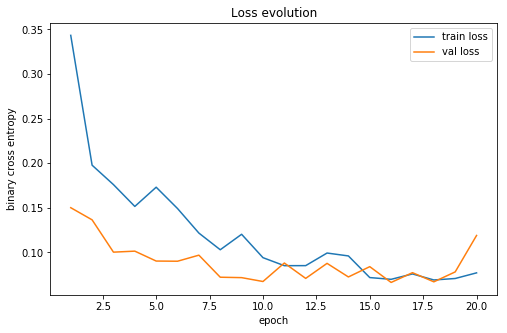

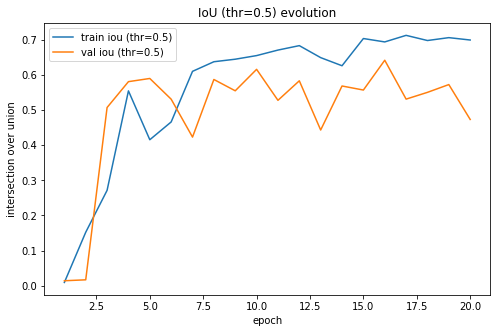

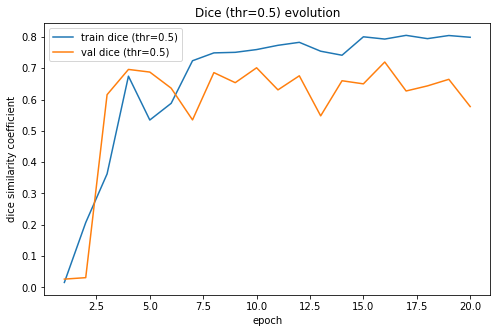

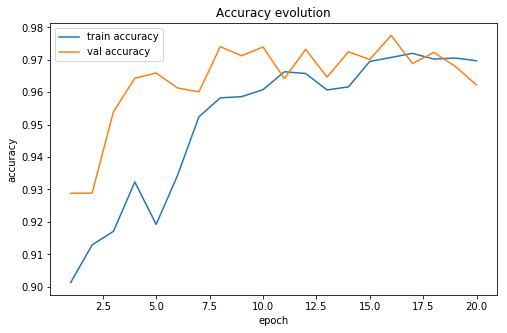

In [13]:
plot_train_val(logs['loss'], logs['val_loss'],
               fig_title='Loss',
               y_label='binary cross entropy')

plot_train_val(logs['tf_jaccard'], logs['val_tf_jaccard'],
               fig_title=f'IoU (thr={config.PRED_THR})',
               y_label='intersection over union')

plot_train_val(logs['tf_dice'], logs['val_tf_dice'],
               fig_title=f'Dice (thr={config.PRED_THR})',
               y_label='dice similarity coefficient')

plot_train_val(logs['acc'], logs['val_acc'],
               fig_title='Accuracy',
               y_label='accuracy')